#### The dataset used here is day_9_test_new.txt , and should be renamed as Test_day_9.txt in order to run the code

Based on https://github.com/JustGlowing/minisom/blob/master/examples/OutliersDetection.ipynb

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [2]:
import pandas as pd
# dataset_train = pd.read_csv("Training_day_9.txt", sep = ",", na_values = ['?','.'])
dataset_test = pd.read_csv("Test_day_9.txt", sep = ",", na_values = ['?','.'])

In [3]:
# dataset_train = dataset_train.drop('Unnamed: 0',1)
# dataset_test = dataset_test.drop('Unnamed: 0',1)
# dataset_train = dataset_train.drop('time',1)
dataset_test = dataset_test.drop('time',1)
dataset_test.rename(columns={'anomaly':'Malignant/Benign'}, inplace=True)

In [4]:
data = dataset_test

In [5]:
# shuffle your dataframe in-place and reset the index. 
# specifying drop=True prevents reset_index from creating a column containing the old index entries
# data = data.sample(frac=1).reset_index(drop=True)

In [6]:
anomaly = data['Malignant/Benign'] # will be resused for the confusion matrix
data = data.drop('Malignant/Benign', 1) # because the model is Unsupervised

### Data processing using factorization

In [7]:
data.iloc[:,0] = pd.factorize(data.iloc[:,0])[0]
data.iloc[:,1] = pd.factorize(data.iloc[:,1])[0]
data.iloc[:,2] = pd.factorize(data.iloc[:,2])[0]
data.iloc[:,3] = pd.factorize(data.iloc[:,3])[0]
data.iloc[:,4] = pd.factorize(data.iloc[:,4])[0]
data.iloc[:,5] = pd.factorize(data.iloc[:,5])[0]
data.iloc[:,6] = pd.factorize(data.iloc[:,6])[0]
data.iloc[:,7] = pd.factorize(data.iloc[:,7])[0]

In [8]:
from sklearn.preprocessing import scale
data = scale(data)

In [9]:
from minisom import MiniSom


som = MiniSom(x = 2, y = 1, input_len = data.shape[1], sigma = 1.0, learning_rate = 0.5,
             neighborhood_function='triangle', random_seed=10)

start_time = time.time()

som.train_batch(data, 100, verbose=True)  # random training

stop_time = time.time()
print("Prediction run in %.2fs" % (stop_time - start_time))

/home/trevor/anaconda3/lib/python3.6/site-packages/minisom.py:123: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


 [ 100 / 100 ] 100% - 2423.38857 it/s - quantization error: 1.9573543888751652
Prediction run in 0.17s


In [10]:
outliers_percentage = 200/10200 

In [11]:
quantization_errors = np.linalg.norm(som.quantization(data) - data, axis=1)
error_treshold = np.percentile(quantization_errors, 
                               100*(1-outliers_percentage)-5)
is_outlier = quantization_errors > error_treshold

Text(0,0.5,'frequency')

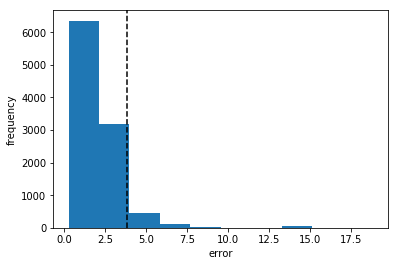

In [12]:
plt.hist(quantization_errors)
plt.axvline(error_treshold, color='k', linestyle='--')
plt.xlabel('error')
plt.ylabel('frequency')

In [13]:
data[~is_outlier, 0].shape

(9490,)

In [14]:
data[is_outlier, 0].shape

(710,)

In [15]:
data.shape

(10200, 8)

In [16]:
is_outlier.shape

(10200,)

In [17]:
V = int(is_outlier == 'true')

/home/trevor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


In [18]:
is_outlier = is_outlier.astype(int) # convert boolean into intergers

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(anomaly, is_outlier)
cm

array([[9405,  595],
       [  85,  115]])

In [20]:
from sklearn.metrics import average_precision_score
average_precision_score(anomaly, is_outlier)

0.10146713615023474

In [21]:
TN, FP, FN, TP = cm.ravel()

print ("TP: ", TP)
print ("FN: ", FN)
print ("FP: ", FP)
print ("TN: ", TN)

TP:  115
FN:  85
FP:  595
TN:  9405


In [22]:
# Performance Matrix
accuracy = (TP+TN)/(TP+FN+FP+TN)
print ("Accuracy: ", np.round(accuracy, 2))
recall = TP/(TP+FN)
print ("recall: ", np.round(recall, 2))
specificity = TN/(TN+FP)
print ("Specificity: ", np.round(specificity, 2))
precision = TP/(TP + FP)
print ("precision: ", np.round(precision, 2))
F1 = 2/((1/precision) + (1/recall))
print ("F1: ", np.round(F1, 2))

Accuracy:  0.93
recall:  0.57
Specificity:  0.94
precision:  0.16
F1:  0.25


In [23]:
data.shape[1]

8